# Topic/User Analysis

## Load Data

In [13]:
import pandas as pd
import numpy as np

ur_df = pd.read_parquet('./../../data/raw/cop26_tweets_en.parquet')
doc_info = pd.read_csv('./../../data/processed/document_info_cop26_tweets_en.csv')[['Document', 'Topic', 'Representative_document','Name']]
doc_info.Topic = doc_info.Topic.astype(int)
embeddings = np.load('./../../data/processed/cop26_tweets_en.parquet.npy')

In [5]:
print(doc_info.columns)

Index(['Document', 'Topic', 'Representative_document', 'Name'], dtype='object')


## Merge dataset
Merge Topic data with Tweets so that (retweets are included).

In [14]:
# merge ur_df with doc_info on 'text'
merged_df = ur_df.merge(doc_info, left_on='text', right_on='Document', how='left')
assert len(merged_df) == len(ur_df), 'differing length before and after merge, duplicates in right'

In [7]:
ur_df.columns

Index(['id', 'author_id', 'created_at', 'lang', 'text', 'retweeted_id',
       'quoted_id', 'replied_id', 'url', 'expanded_url', 'hashtags',
       'retweet_count', 'reply_count', 'like_count', 'quote_count', 'username',
       'individual_or_org', 'category'],
      dtype='object')

## Assign Topic to Users
Group topics by users, and assign using a threshold 

In [ ]:
# Function to select dominant topics
from collections import Counter

def get_user_dominant_topic(topics, threshold=0.5, exclude=-1):
    """
    Args:
        topics (list): list of topic labels for a user.
        threshold (float): minimum fraction (e.g., 0.5 for 50%) for dominance.
        exclude (int or list): topic(s) to exclude, e.g. -1 for bertopic Noise.
    
    Returns:
        int or None: dominant topic if above threshold, else None
    """
    if isinstance(exclude, int):
        topics = [t for t in topics if t != exclude]
    elif isinstance(exclude, list):
        topics = [t for t in topics if t not in exclude]

    if not topics:
        return None

    total = len(topics)
    topic_counts = Counter(topics)
    top_topic, top_count = topic_counts.most_common(1)[0]
    
    if top_count / total >= threshold:
        return int(top_topic)
    return None


Confront user retention using different thresholds

In [ ]:
user_topics = merged_df.groupby('author_id')['Topic'].apply(list)

# Try with 30% threshold
user_dominant_topic_30 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, threshold=0.3))

# Try with 50% threshold
user_dominant_topic_50 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, threshold=0.5))

# Try with 60% threshold
user_dominant_topic_60 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, threshold=0.6))

# Combine into a DataFrame for comparison
result = pd.DataFrame({
    'dominant_topic_30': user_dominant_topic_30,
    'dominant_topic_50': user_dominant_topic_50,
    'dominant_topic_60': user_dominant_topic_60
})

Verify how many users have a defined value

In [45]:
print(f"NaN with 30% threshold:\t{float(round(1 - result.dominant_topic_30.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with 50% threshold:\t{float(round(1 - result.dominant_topic_50.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with 60% threshold:\t{float(round(1 - result.dominant_topic_60.isna().sum()/len(result), 2)*100)}%")

NaN with 30% threshold:	23.0%
NaN with 50% threshold:	9.0%
NaN with 60% threshold:	6.0%


Topics are floats because some topics are NaN
Will eliminate NaN and convert dtype to int when final results will be added

In [55]:
#result.dominant_topic_30 = result.dominant_topic_30.astype(int)
result.dtypes

dominant_topic_30    float64
dominant_topic_50    float64
dominant_topic_60    float64
dtype: object

## Combine with user metadata
Load metadata and explore results

In [46]:
# `user_metadata` is a DataFrame with columns like:
# 'id', 'individual_or_org', 'category'
user_metadata = pd.read_csv("./../../data/raw/influencers_summary_cop26.csv")
user_metadata.columns

Index(['id', 'username', 'individual_or_org', 'category', 'num_of_rt',
       'num_of_retweeters', 'V1', 'followers_count', 'following_count',
       'tweet_count', 'listed_count'],
      dtype='object')

In [47]:
# Merge with user-topic assignments from previous step
combined_df = user_metadata.merge(result[['dominant_topic_50']], left_on='id', right_on='author_id')

Use crosstabs and grouped bar plots to explore distributions.

In [48]:
pd.crosstab(combined_df['individual_or_org'], combined_df['dominant_topic_50'], normalize='index')

dominant_topic_50,0.0,2.0,4.0,8.0,9.0,10.0,12.0,14.0,15.0,18.0,...,62.0,65.0,66.0,69.0,72.0,73.0,81.0,84.0,126.0,183.0
individual_or_org,,,,,,,,,,,,,,,,,,,,,
Individual,0.142857,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.071429,...,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000
Organization,0.029412,0.088235,0.000000,0.029412,0.176471,0.058824,0.088235,0.058824,0.029412,0.000000,...,0.029412,0.000000,0.029412,0.029412,0.029412,0.000000,0.000000,0.029412,0.029412,0.029412


In [37]:
pd.crosstab(combined_df['category'], combined_df['dominant_topic_50'], normalize='index')

dominant_topic_50,0.0,2.0,4.0,8.0,9.0,10.0,12.0,14.0,15.0,18.0,...,62.0,65.0,66.0,69.0,72.0,73.0,81.0,84.0,126.0,183.0
category,,,,,,,,,,,,,,,,,,,,,
Activist,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.5,0.000000
International Organization / NGO,0.047619,0.142857,0.047619,0.047619,0.238095,0.000000,0.142857,0.047619,0.000000,0.00,...,0.095238,0.0,0.047619,0.000000,0.0,0.00,0.00,0.000000,0.0,0.047619
Media,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.111111,0.00,...,0.000000,0.0,0.000000,0.111111,0.0,0.00,0.00,0.000000,0.0,0.000000
Other,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.142857,0.0,0.000000
Politics,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,...,0.000000,0.2,0.000000,0.000000,0.2,0.00,0.00,0.000000,0.0,0.000000
Private Individual,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,...,0.000000,0.0,0.000000,0.000000,0.0,0.25,0.25,0.000000,0.0,0.000000


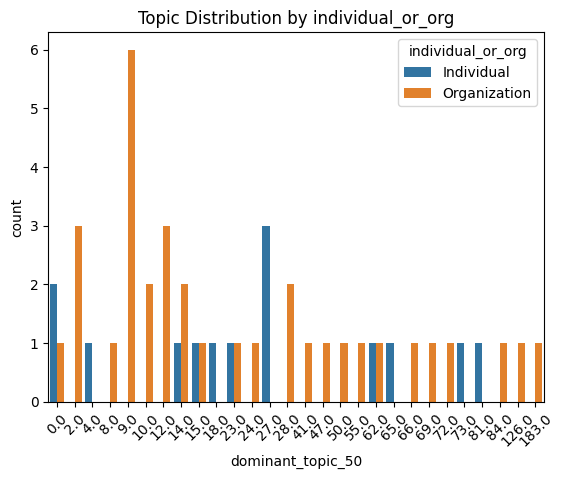

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=combined_df, x='dominant_topic_50', hue='individual_or_org')
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

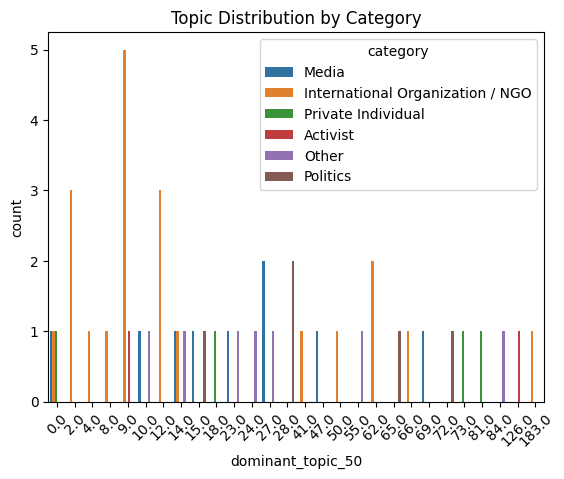

In [ ]:


sns.countplot(data=combined_df, x='dominant_topic_50', hue='category')
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()


## Statistical Test for Association
### Chi²
Use Chi² for categorical association, and Cramer's V
Low p-value (e.g. < 0.05) → strong evidence that topic assignment and political leaning are not independent.
### Cramer's V 
Interpretation of effect size

|Effect size (ES) | Interpretation|
| --------- | --------- |
|ES ≤ 0.2	| The result is weak. Although the result is statistically significant, the fields are only weakly associated.|
|0.2 < ES ≤ 0.6	| The result is moderate. The fields are moderately associated.|
|ES > 0.6	| The result is strong. The fields are strongly associated.|


### Individual or Organization

In [61]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(combined_df['individual_or_org'], combined_df['dominant_topic_50'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}, p-value: {p}")


Chi-square statistic: 34.285714285714285, p-value: 0.1578980035941924


In [62]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

cramers_v(contingency_table)


np.float64(0.8451542547285166)

### Category

In [63]:
contingency_table = pd.crosstab(combined_df['category'], combined_df['dominant_topic_50'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}, p-value: {p}")


Chi-square statistic: 167.5809523809524, p-value: 0.029891048139673495


In [64]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

cramers_v(contingency_table)


np.float64(0.8356159214938215)